### Theoretical Part

##### Hypothesis Testing: the problem of multiple comparisons 

Given that:
- $\alpha$ is the Type I error for each test
- $\beta$ is the Type II error
- $1 - \beta$ is the power

a) P($m^{th}$ experiment gives significant result | $m$ experiments lacking power to reject $H_0$) = $\alpha (1 - \beta)^{m-1}$,

where $(1 - \beta)^{m-1}$ is the probability that the first $m - 1$ experiments correctly conclude that the result is not significant, and $\alpha$ is the probability that the next experiment will yield a Type I error. We can rephrase this event as
> Experiment 1 correctly rejects $H_0$ **AND** Experiment 2 correctly rejects $H_0$ **AND ... AND** Experiment $m$ yields a Type I error.

b) P(at least one significant result | $m$ experiments lacking power to reject $H_0$) = $m \alpha$. 

We can rephrase this event as 
> Experiment 1 yields a Type I error **OR** Experiment 2 yields a Type I error **OR ... OR** Experiment $m$ yields a Type I error.

which can be translated into an $m$-fold addition of the Type I error probability $\alpha$.

##### Bias and unfairness in Interleaving experiments

We present a situation where interleaving should produce a preference for one of the two ranking lists but 
it fails to do so and it assigns equal expected winning probability to both rankings.

Let $d_3$ be the only relevant document, i.e. the only document the user will click on.
In list A, $d_3$ is ranked as third, whereas $d_3$ is in the second position of Ranking A. Therefore, Ranking B is expected to win more often than Ranking B. Consider, however, the following rankings and the four lists that can be generated using Team Draft Interleaving:

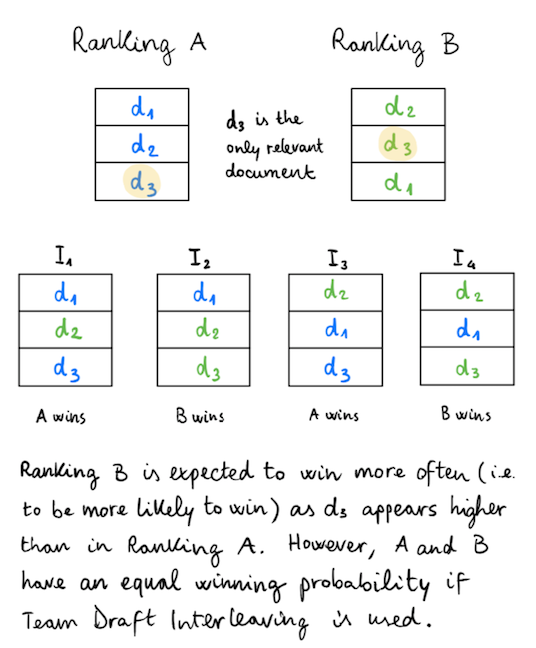

In [6]:
from IPython.display import Image
Image("interleaving_bias.png")

In [1]:
# Step 1: Simulate Rankings of Relevance for E and P

import itertools

relevance = [0, 1, 2]  # 0: N, 1: R, 2: HR
combinations = list(itertools.product(relevance, repeat=5))
ranking_pairs = list(itertools.product(combinations, repeat=2))

# delete ratings that are the same for both  
for i,k in enumerate(ranking_pairs):
    if k[0] == k[1]:
        del ranking_pairs[i]
k = 10
for pair in ranking_pairs[:k]:
    print(pair)
    
    

((0, 0, 0, 0, 0), (0, 0, 0, 0, 1))
((0, 0, 0, 0, 0), (0, 0, 0, 0, 2))
((0, 0, 0, 0, 0), (0, 0, 0, 1, 0))
((0, 0, 0, 0, 0), (0, 0, 0, 1, 1))
((0, 0, 0, 0, 0), (0, 0, 0, 1, 2))
((0, 0, 0, 0, 0), (0, 0, 0, 2, 0))
((0, 0, 0, 0, 0), (0, 0, 0, 2, 1))
((0, 0, 0, 0, 0), (0, 0, 0, 2, 2))
((0, 0, 0, 0, 0), (0, 0, 1, 0, 0))
((0, 0, 0, 0, 0), (0, 0, 1, 0, 1))


In [2]:
def average_precision(query_judgement):
    l = []
    rel_docs = 0
    
    for i, judgement in enumerate(query_judgement, start=1):
        if judgement != 0:
            rel_docs += 1
            l.append(rel_docs / i)
            
    if rel_docs == 0:
        return 0
    
    return sum(l) / rel_docs       

In [3]:
from math import log

def dcg(query_judgement, k):
    query_judgement = list(query_judgement)[:k]
    dcg = 0
    
    for i, judgement in enumerate(query_judgement, start=1):
        dcg += (2 ** judgement - 1) / log(i + 1, 2)
        
    return dcg

def ndcg(query_judgement, k):
    perfect_ordering = sorted(query_judgement, reverse=True)
    perfect_score = dcg(perfect_ordering, k)
    
    if perfect_score == 0:
        return 0
    
    return dcg(query_judgement, k) / perfect_score

In [4]:
max_rel = 2  # ad-hoc for 3 different judgements
satisfaction_probs = [(2 ** rel - 1) / 2 ** max_rel for rel in range(3)]

def err(query_judgement):
    sat_probs = []
    
    for rel in query_judgement:
        sat_probs.append(satisfaction_probs[rel])
        
    err = 0
    
    for i in range(1, len(query_judgement) + 1):
        prod = sat_probs[i - 1]
        
        for j in range(1, i):
            prod *= 1 - sat_probs[j]
        
        err += prod / i
    
#     if err == 0:
#         return len(query_judgement)
    
    return err

In [5]:
max_rel = 2  # ad-hoc for 3 different judgements
satisfaction_probs = [(2 ** rel - 1) / 2 ** max_rel for rel in range(3)]

def err(query_judgement):
    sat_probs = []
    
    for rel in query_judgement:
        sat_probs.append(satisfaction_probs[rel])
        
    err = 0
    prod = 1
    
    for i in range(1, len(query_judgement) + 1):
        rel_prob = sat_probs[i - 1]
        
        err += prod * rel_prob / i
        prod *= 1 - rel_prob
            
#     if err == 0:
#         return len(query_judgement)
    
    return err

In [6]:
print(1/ err(ranking_pairs[11][1]))

7.6800000000000015


In [7]:
ranking_pairs[242][1]

(0, 0, 0, 0, 0)

In [8]:
import random
import copy


def team_draft_interleaving(list_a, list_b):
    '''
    Implementation of the team draft interleaving algorithm
    Args:
        a, b: list
    Return:
        interleaved_list, chosen_list
    '''
    final_list = []
    chosen = []  # list containing a/b values

    # This is done so that, original lists are not modified
    a = copy.deepcopy(list_a)
    b = copy.deepcopy(list_b)
    
    while (len(a) > 0 and len(b) > 0):
        choose_a = bool(random.getrandbits(1))

        label_add = ['a', 'b']

        current_a = a.pop(0)
        current_b = b.pop(0)

        to_add = list(set([current_a, current_b]))

        if not choose_a:
            to_add = to_add[::-1]  # reverse list
            label_add = label_add[::-1]

        # TODO: Check if t
        if len(to_add) == 1:
            del label_add[1]
            
        final_list += to_add
        chosen += label_add

        if current_b in a: a.remove(current_b)
        if current_a in b: b.remove(current_a)

    return final_list, chosen

In [9]:
def simulate_clicks(doc_size, num_clicks=2):
    return random.sample(range(doc_size), num_clicks)

In [10]:
def team_draft_credit(pointer_list, simulated_clicks):
    
    credit_a, credit_b = 0, 0
    
    for idx in simulated_clicks:
        credit_a += pointer_list[idx] == 'a'
        credit_b += pointer_list[idx] == 'b'
    
    return credit_a, credit_b

In [17]:
a = [1, 2, 3, 4]
b = [2, 3, 4, 1]

interleaved, pointers = team_draft_interleaving(a, b)
clicks = simulate_clicks(len(a), 2)

print('-'*51)
print('interleaved     :', interleaved)
print('pointers     :', pointers)
print('clicks       :', [interleaved[c] for c in clicks], ' {NOTE: these are docIDs}')
print('credit (a, b):', team_draft_credit(pointers, clicks))
print('-'*51)

---------------------------------------------------
interleaved     : [2, 1, 3, 4]
pointers     : ['b', 'a', 'a', 'b']
clicks       : [2, 1]  {NOTE: these are docIDs}
credit (a, b): (1, 1)
---------------------------------------------------


In [23]:
## click models

# data:  SessionID, TimePassed, TypeOfAction, QueryID, RegionID, ListOfURLs

data = []
with open("YandexRelPredChallenge.txt","r") as yandex:
    
    for line in yandex:
        print(line)
        data.append(line.strip().split('\t'))
    

0	0	Q	8	0	7	103	51	92	43	12	73	69	27	105

0	36	Q	174	0	1625	1627	1623	1626	1624	1622	1619	1621	1620	1618

0	50	Q	227	0	2094	2091	2087	2089	2093	2088	2090	2092	2095	2086

0	515	Q	174	0	1625	1627	1623	1626	1624	1622	1619	1621	1620	1618

0	524	Q	1974	0	17562	1627	1626	1623	2091	17559	17563	17558	17561	17560

0	527	C	17562

0	528	C	1627

0	529	C	1626

1	0	Q	9	0	13	70	66	94	50	104	29	21	89	85

1	20	C	104

1	123	C	21

1	291	Q	1324	0	11807	11805	11812	11813	11804	11809	11806	11811	11808	11810

1	301	C	11813

1	8605	C	11808

1	8737	C	11810

1	8884	C	11811

2	0	Q	7	0	77	93	55	86	64	67	76	98	18	54

2	11	C	18

2	1122	Q	4088	0	35554	35561	35562	35556	35557	35567	35550	35566	35568	35553

2	1127	C	35561

2	1645	Q	5863	0	36505	36514	36508	36509	50480	36510	36507	50482	50483	50481

2	1646	C	36505

3	0	Q	1	0	15	32	0	9	80	30	88	82	97	65

3	40	Q	32	0	314	230	338	282	335	257	216	241	342	281

3	95	Q	431	0	3884	0	3887	3888	3889	3885	3882	3881	3886	3883

3	103	C	3884

3	7367	Q	23323	0	191148	191149	191144	19

163	304	C	1287

163	965	C	1258

163	7245	Q	24214	0	198158	198167	198162	198165	198161	198159	198160	198164	198163	198166

163	7294	C	198162

163	7390	Q	24691	0	198158	198165	198167	198162	198160	198164	201915	201916	201914	201917

163	7454	Q	24845	0	198158	201917	198164	198160	198162	203091	203083	203101	203100	203092

163	7521	Q	25036	0	204640	204641	204639	204636	204630	204633	204637	204631	204638	204629

163	7565	C	204631

163	7649	Q	25441	0	207885	207884	207883	207882	207880	204636	207887	207886	207888	207881

163	7742	Q	25721	0	207880	210035	207885	210033	210034	207884	204636	204641	210031	210032

163	8114	Q	26616	0	207887	207885	210034	207882	204636	217175	217177	207888	217176	207881

163	8930	Q	28671	0	233643	233644	233645	159885	233646	233649	233651	233648	233650	233647

163	8985	Q	28810	0	234783	1254	234779	234777	234780	234782	201915	198167	234781	234778

163	14279	Q	39920	0	321726	321723	321722	321720	252693	321724	321725	321727	133340	321721

163	14294	C	321723

163	14601	Q

457	206	Q	1236	0	11032	11030	11037	11029	11036	11035	11033	11034	11038	11031

457	217	C	11032

457	1270	Q	5000	0	43317	43311	43313	43315	11038	17415	43310	43316	43314	43312

457	1276	C	43317

457	1369	C	43314

457	1534	Q	16	0	206	154	179	180	130	164	146	112	139	201

457	1622	C	206

458	0	Q	369	0	3372	3368	3281	3293	3297	3361	3309	3367	3371	3354

458	338	Q	369	0	3372	3368	3281	3293	3297	3361	3309	3367	3371	3354

458	1319	Q	5061	0	43807	43808	43813	43809	43804	43812	43810	43811	43806	43805

458	1346	C	43804

458	1349	C	43807

458	1355	C	43812

458	2367	Q	94	0	960	895	965	131	936	197	167	964	930	959

458	2630	C	960

458	2635	C	895

458	2718	C	965

459	0	Q	373	0	3311	3313	3325	3302	3316	3323	3329	3331	3348	3278

459	8	C	3311

459	21	C	3313

459	352	C	3302

459	528	C	3331

459	732	C	3348

460	0	Q	289	1	349	2656	2660	2570	45	2583	2581	3349	3282	3277

460	67	Q	623	1	451	434	452	517	438	1246	5628	5627	2693	5629

460	84	C	451

461	0	Q	366	0	3280	3333	3356	3283	3347	3341	3357	3328	3337	3321

461

711	1111	C	38402

711	1112	C	38398

711	1115	C	38397

711	1883	Q	7136	0	19202	19228	19213	19211	19221	61094	19204	61085	61095	61087

711	1886	C	19202

711	1887	C	19228

711	1888	C	19213

711	1967	Q	7390	0	63234	63235	61085	63239	63237	63242	63236	63238	63240	63241

711	1970	C	63234

711	1971	C	63235

711	2040	Q	7644	0	65382	65383	65387	65385	65379	65380	65381	65386	65384	19213

711	2045	C	65383

711	2051	C	65385

711	2052	C	65380

711	4603	Q	4423	0	38399	37661	38402	38398	38397	38400	38396	38401	37743	37655

711	4606	C	38399

711	8057	C	38399

712	0	Q	560	0	5056	5047	5122	5057	5083	5091	5086	5118	5078	5049

712	28	Q	667	0	6024	5056	6022	6027	6016	6021	6031	6017	6028	6029

713	0	Q	318	0	2903	2929	2894	2956	2893	2890	2900	2940	2943	2933

713	5	C	2903

713	6204	Q	20429	0	168256	82211	34343	168252	168264	168258	59551	168259	168262	168266

713	6348	Q	20840	0	65670	171433	44905	171431	82211	34329	116086	171429	171430	171432

713	6358	C	171433

713	7306	Q	23548	0	98641	34343	82208	192955	9803


1000	2017	C	649

1000	2725	Q	758	1	661	649	2901	505	454	2706	653	2760	6853	1565

1000	3768	C	6853

1001	0	Q	162	0	1514	1519	1442	1526	1423	1437	1436	1449	1461	1495

1001	11	C	1519

1001	2037	C	1519

1001	4125	Q	16983	0	140814	140823	140821	140818	140820	140816	140819	140822	140815	140817

1001	4162	C	140822

1002	0	Q	764	0	6869	6883	6877	6871	6886	6835	6855	6875	6851	6863

1002	1500	Q	26	0	341	246	233	280	289	301	277	299	334	315

1002	1515	C	341

1003	0	Q	7	0	77	18	93	55	86	64	67	76	98	54

1003	15	C	18

1005	0	Q	763	1	6846	6852	6847	6860	6862	6858	6836	6872	6892	6870

1005	30	C	6846

1005	364	C	6870

1005	1422	Q	6232	1	44390	44392	44386	3194	53536	53535	53537	53538	53540	53539

1006	0	Q	761	0	6859	6842	6848	6882	6856	6865	6891	6840	6838	6868

1006	100	C	6865

1006	383	Q	449	0	4043	4001	4022	4046	4048	4015	4056	4016	4029	3989

1006	394	C	4043

1006	454	Q	2591	0	22879	22889	22894	22891	22885	22893	22888	22882	20292	22892

1006	459	C	22879

1006	1491	Q	6121	0	52623	52614	52621	52620	5261

1251	317	C	15245

1251	938	Q	16	0	206	154	179	180	130	164	146	112	139	201

1251	950	Q	114	0	206	154	1083	1082	179	180	1085	1084	1086	112

1251	958	C	154

1251	1598	Q	6623	0	56716	56718	56719	56711	56712	56715	56713	56714	56710	56717

1251	1666	C	56717

1252	0	Q	945	0	8563	8527	8559	8548	8551	8547	8565	8533	8538	8534

1252	61	C	8551

1252	385	Q	209	0	1935	1954	1922	1920	1911	1932	1910	1937	1938	1902

1252	398	C	1911

1252	647	Q	3400	0	29794	29797	29802	29787	29788	29785	29786	29796	29799	29792

1252	654	Q	3429	0	1910	30051	30049	30050	30047	30046	1911	30045	30048	30044

1252	660	C	1910

1254	0	Q	253	1	2356	2275	2372	2277	2310	2291	2273	2333	2258	7371

1254	47	C	7371

1254	91	C	2258

1254	443	Q	2716	1	23929	17796	23933	1980	23928	23906	23919	23916	23922	23932

1254	456	C	23929

1254	535	C	23932

1254	1003	Q	4814	1	41773	5963	570	5615	6822	29446	41777	18478	41771	41775

1254	1014	C	5963

1254	1051	C	29446

1254	2045	C	41771

1255	0	Q	16	0	206	154	179	180	130	164	146	112	139	201

1255	62	Q

1453	325	Q	2375	0	21058	21053	21061	21060	21059	21057	21062	21055	21054	21056

1453	343	C	21061

1453	659	C	21055

1453	750	C	21055

1453	6044	Q	853	0	7686	7717	7700	7679	7716	7722	7672	7694	7684	7683

1453	6047	C	7686

1453	6580	C	7717

1453	6666	C	7700

1453	6842	C	7679

1453	7055	Q	24770	0	7686	7700	202490	202487	202486	202488	202491	202492	7716	202489

1453	7061	C	202490

1453	7123	Q	24964	0	204081	204082	204078	204084	204083	204085	7700	204080	202491	204079

1453	7126	C	204081

1453	7185	C	204082

1453	7235	Q	25327	0	206932	13358	206938	202490	206939	206936	206933	206937	206934	206935

1453	7238	C	206932

1453	7453	C	13358

1453	7849	Q	27156	0	221497	221501	221495	221496	6201	4710	6214	221499	221498	221500

1453	7854	C	221497

1453	8047	C	221501

1453	8155	C	221496

1453	8195	C	6201

1454	0	Q	1121	0	9964	9970	10033	10024	9974	10046	9983	10052	10045	9987

1454	22	C	9983

1454	1414	Q	6045	0	52006	52001	52003	52000	52009	52002	52004	52008	52007	52005

1454	1448	C	52002

1454	1839	Q	3


1737	1784	Q	7519	0	64325	63540	64324	64331	64332	64330	64328	64326	64327	64329

1737	1875	Q	7427	0	63543	63533	63541	63539	63537	63540	63536	63544	63542	63534

1737	1878	C	63543

1738	0	Q	1345	0	12021	12020	12015	12025	12023	12005	11996	12016	12024	12019

1738	6	C	12021

1738	1165	C	12021

1738	2761	Q	162	0	1514	1519	1442	1526	1423	1437	1436	1449	1461	1495

1738	2767	C	1514

1738	3765	Q	15301	0	127394	127401	127392	127396	127400	127393	127399	127398	127397	127395

1738	3771	C	127394

1738	3819	Q	15483	0	128847	128850	128844	128852	128849	128853	128846	128848	128851	128845

1738	3847	Q	15562	0	129522	129526	129527	128850	129523	129525	129521	129524	129529	129528

1738	3857	C	129522

1738	4358	C	129526

1738	4371	C	129523

1739	0	Q	104	0	649	505	653	638	982	1013	1072	1033	1060	1018

1739	5	C	649

1739	30	C	638

1739	45	C	1072

1740	0	Q	1344	1	12022	12006	12003	11994	12000	12004	12017	11987	11992	12012

1740	47	C	12003

1740	140	C	12006

1740	948	Q	1344	1	12022	12006	12003	11994	12000	12


1982	12	Q	1580	0	13600	14017	13617	13593	14016	14012	14015	14026	14022	14013

1982	15	C	13600

1982	507	Q	3359	0	29437	29436	29439	29438	29434	29435	29441	29432	29433	29440

1982	1239	Q	5299	0	16046	45751	45761	45741	45747	45745	45762	45760	45748	16088

1982	1264	C	16046

1982	1571	Q	1807	0	16046	16050	16038	16081	16078	16064	16088	16048	16063	16071

1982	1576	C	16050

1982	3037	Q	11657	0	98035	98043	98037	98038	98040	98039	98036	98042	98034	98041

1982	3061	Q	11748	0	98767	98779	98771	98778	98768	98769	98774	98770	98777	98780

1982	3085	Q	11839	0	99492	99489	99495	99496	99491	99493	99494	99488	99487	99490

1982	3096	C	99489

1982	3573	Q	13440	0	98037	112412	112407	112415	112409	112411	112413	112408	112410	112414

1982	3588	C	112412

1982	3684	Q	13813	0	115475	115478	115471	115474	115477	115476	115469	115472	115473	115470

1982	3689	C	115475

1982	3867	C	115471

1982	5367	Q	19057	0	157437	157430	157428	157429	157432	157433	157434	157431	157435	157436

1982	5370	C	157437

1982	5432	C	1

2251	3535	Q	16	1	206	180	34501	84732	179	3757	139	146	113062	9272

2251	3540	C	206

2252	0	Q	128	0	329	300	306	266	1217	1242	1219	337	1238	1214

2252	8	C	329

2253	0	Q	1768	0	1481	2782	15731	15736	15715	15740	15710	15717	15727	15704

2253	8	C	1481

2254	0	Q	1770	0	15757	15700	15734	15733	15737	15723	15735	15702	15741	15706

2254	45	Q	1939	0	17247	17245	17249	17248	17234	17235	17253	17243	17250	17232

2254	50	C	17247

2254	122	Q	2249	0	19950	19949	19948	19947	19955	12601	19951	19953	19954	19952

2254	177	Q	2447	0	21673	21674	21675	21668	21672	21670	21667	21669	21671	21676

2254	188	C	21673

2254	238	Q	2249	0	19950	19949	19948	19947	19955	12601	19951	19953	19954	19952

2254	281	Q	2851	0	25088	25080	25083	25086	25081	25087	25082	25084	25089	25085

2254	294	C	25080

2254	382	C	25087

2254	662	Q	4322	0	37544	37547	37548	37546	37553	37550	37552	37549	37551	37545

2254	677	C	37544

2254	725	Q	4569	0	1604	39625	39626	39622	39620	39618	39624	39619	39621	39623

2254	738	C	1604

2254	896	C	39625



2480	0	Q	449	3	4043	4046	4480	4464	4450	4445	4463	4446	4471	144

2480	3	C	4043

2480	135	C	4043

2480	6708	Q	23108	3	189342	85988	189341	5231	85989	189340	189338	57893	16357	189339

2481	0	Q	189	0	219	857	332	272	262	1828	1694	256	333	869

2481	414	C	219

2481	567	C	219

2481	876	Q	5814	0	50054	50061	50050	50062	50055	50052	50065	50059	50048	50067

2481	886	C	50061

2481	914	C	50061

2481	1131	C	50050

2481	1241	C	50050

2481	1314	C	50055

2481	1450	C	50052

2481	1514	Q	8634	0	50059	50048	73575	73576	64428	73572	73574	50054	73577	73573

2481	1522	C	50059

2481	1824	Q	9663	0	32747	81970	50067	81964	81969	81965	81967	32752	81968	81966

2481	1844	C	32747

2481	2170	Q	2261	0	219	256	332	865	20044	333	847	868	2950	1712

2481	2176	C	219

2481	2281	C	868

2483	0	Q	39	0	354	344	402	404	346	391	357	367	420	356

2483	6	C	354

2484	0	Q	276	0	2346	1723	2516	2535	2530	2531	2517	2529	2520	2527

2484	5	C	2346

2484	89	Q	616	0	2360	1723	5603	5604	5564	5620	5592	5570	5591	5568

2484	145	C	2360

2484	7

2691	96	Q	2512	0	19214	22246	19213	22231	22228	22244	22238	22245	22218	22243

2691	252	Q	3073	0	19213	22218	27012	27015	27013	22238	27010	27016	27011	27014

2691	260	C	22218

2691	615	Q	111	0	990	985	978	991	1041	1003	1032	1047	1029	1053

2691	620	C	990

2691	780	Q	4936	0	42760	42762	42757	42761	34229	42763	42759	42765	42758	42764

2691	1020	Q	5689	0	49013	49001	49007	49005	16086	49010	49000	49006	49002	49011

2691	1332	Q	6700	0	57411	57412	57414	57417	57419	57415	57418	57420	57413	57416

2691	6369	Q	843	0	2935	7639	2908	990	7607	2902	2925	2951	7233	7638

2691	6389	C	7639

2691	6392	C	2935

2691	13428	Q	317	0	2935	2902	2879	990	2908	2951	2925	2909	2875	2953

2691	13433	C	2935

2691	13443	C	2902

2691	13454	C	2879

2692	0	Q	297	1	438	451	2699	1860	2746	2688	2701	2734	2693	2692

2692	6	C	451

2692	3690	Q	14280	1	15180	119253	119258	119248	119272	119251	119266	119245	119273	119254

2692	5266	Q	18957	1	156667	156661	156665	156660	156664	156666	156662	156663	156658	156659

2692	6168	Q	18957


2902	3766	Q	14712	1	122685	122684	122678	122683	122679	122676	122681	122677	122682	122680

2902	3771	C	122684

2902	3922	Q	14712	1	122685	122684	122678	122683	122679	122676	122681	122677	122682	122680

2902	4034	Q	15546	1	79180	129382	129379	129383	129377	129378	129384	129385	129380	129381

2902	4046	Q	15576	1	129635	129628	129629	129632	129633	63109	129636	129634	129631	129630

2902	4078	C	129628

2902	6619	Q	23075	1	59608	10112	129131	189109	1147	181912	39695	189110	189108	189107

2902	6704	C	59608

2902	7150	Q	24706	1	2715	2757	30259	2724	202037	30251	202036	202038	32104	202035

2902	7153	C	2715

2902	10695	Q	13464	1	112607	112632	112601	112608	112610	112618	112613	112634	112631	112614

2902	10701	C	112601

2903	0	Q	104	0	649	505	653	638	982	1013	1072	1033	1060	1018

2903	8	C	1072

2904	0	Q	2358	0	20922	20899	20884	20855	20911	20933	20903	20852	20917	20849

2904	37	C	20899

2904	1455	Q	7307	0	20899	62544	62554	62549	62543	62545	62551	62539	62547	62538

2904	1494	C	62549

2904	1594	

3127	1123	Q	891	0	191	155	158	150	8046	161	196	8027	8056	186

3127	1124	C	191

3127	4335	Q	47	0	482	425	456	464	474	580	566	60	532	533

3127	4338	C	482

3127	4618	Q	17448	0	144592	144589	144597	144594	144588	144595	144591	144590	144593	144596

3127	4621	C	144592

3128	0	Q	86	0	810	842	855	813	864	879	814	809	875	815

3128	3	C	810

3128	394	C	842

3128	3000	Q	1970	0	17530	17522	17525	17521	17523	17528	17526	17529	17520	17527

3129	0	Q	94	0	960	895	965	131	936	197	167	964	930	959

3129	136	C	960

3130	0	Q	76	1	14250	797	14274	751	796	14279	14265	14270	14282	14301

3130	86	C	797

3131	0	Q	2569	0	22711	22690	22723	22719	22693	22707	22715	22721	22716	22698

3131	34	C	22711

3131	1042	Q	6159	0	52943	52955	52954	52949	52944	52950	52945	52951	52948	52941

3131	1060	C	52943

3131	2497	Q	336	0	3048	3081	3034	3044	3007	2999	3013	3003	3023	6687

3131	2565	C	3003

3131	3856	Q	15287	0	127298	127305	127302	127303	127301	127300	127307	127306	127304	127299

3131	3889	Q	15396	0	128162	128159	127299	3036


3392	12973	C	315470

3393	0	Q	276	0	2346	1723	2516	2535	2530	2531	2517	2529	2520	2527

3393	1	C	2346

3394	0	Q	0	0	59	89	29	61	25	2	63	42	94	71

3394	13	C	59

3395	0	Q	297	0	438	451	2693	2692	1860	4923	434	4903	4933	2746

3395	8	C	438

3395	747	Q	5382	0	46409	46407	33817	8735	46411	46403	46396	45865	46406	46410

3395	774	C	46411

3395	809	C	45865

3395	1109	Q	6622	0	56708	56709	56706	56707	56701	56703	56705	56704	56700	56702

3396	0	Q	2810	1	1566	24727	24718	5442	5449	24721	24724	24723	24720	24719

3396	3	C	1566

3396	1831	Q	8860	1	75417	75421	75422	75424	75425	75420	75419	75416	75418	75423

3396	1837	C	75417

3396	1845	C	75420

3396	2833	Q	12167	1	102153	102152	102155	102146	102147	102154	102149	102150	102148	102151

3396	2843	C	102152

3396	2931	Q	12510	1	104792	104800	104793	104794	104795	104799	104796	104798	104801	104797

3396	2937	C	104800

3397	0	Q	735	0	6656	6603	6608	6646	6668	6669	6607	6662	6628	6626

3397	189	Q	3468	0	30391	30392	6668	6669	6608	30385	6626	30393	6603	26415




3630	0	Q	2999	0	25566	26385	26388	26368	26367	26387	26391	26383	26374	26366

3630	5	C	25566

3630	53	Q	3185	0	25327	27983	3587	3623	27978	27982	3642	27981	27980	27979

3630	58	C	25327

3630	751	Q	834	0	45	24	7482	7549	20	2742	7552	7513	937	2711

3630	756	C	45

3630	1231	Q	3185	0	25327	27983	3587	3623	27978	27982	3642	27981	27980	27979

3630	1236	C	25327

3630	1648	Q	834	0	45	24	7482	7549	20	2742	7552	7513	937	2711

3630	1653	C	45

3630	2565	Q	3185	0	25327	27983	3587	3623	27978	27982	3642	27981	27980	27979

3630	2570	C	25327

3630	2846	Q	834	0	45	24	7482	7549	20	2742	7552	7513	937	2711

3630	2851	C	45

3630	4000	Q	3185	0	25327	27983	3587	3623	27978	27982	3642	27981	27980	27979

3630	4005	C	25327

3630	4113	Q	834	0	45	24	7482	7549	20	2742	7552	7513	937	2711

3630	4118	C	45

3630	4182	Q	16543	0	137288	123049	137289	137291	123048	137290	137286	137284	137287	137285

3630	4263	C	137288

3630	5280	Q	19895	0	164058	164061	164062	164056	164064	164059	164057	164055	164060	164063

3630	5295	C	16

3792	6699	Q	94	0	960	895	965	131	936	197	167	964	930	959

3792	6702	C	960

3792	6710	C	131

3793	0	Q	35	0	353	414	372	350	384	348	411	389	386	410

3793	6	C	353

3794	0	Q	3159	0	27780	27760	27765	27763	27766	27755	27744	27753	27747	27751

3794	674	Q	25	0	215	239	258	283	235	210	284	328	255	222

3794	677	C	215

3794	1769	Q	8980	0	76226	76355	76360	45	76354	76361	76356	76357	76359	76358

3794	1777	C	76226

3794	2677	Q	11953	0	100416	100412	100415	100409	100410	100413	100411	100414	100418	100417

3794	2678	C	100416

3794	8390	Q	8980	0	76226	76355	76360	45	76354	76361	76356	76357	76359	76358

3794	8405	C	76226

3794	9463	Q	8980	0	76226	76355	76360	45	76354	76361	76356	76357	76359	76358

3794	9464	C	76226

3795	0	Q	3161	0	19992	27767	27771	27754	27781	27777	27752	27769	27772	27788

3795	16	Q	3225	0	9036	19992	28316	28323	28309	28307	28312	28318	28317	28314

3795	35	Q	3290	0	9036	19992	28316	28312	28849	219	16775	28309	16705	28307

3795	36	C	9036

3795	291	C	19992

3795	294	C	28316

3795	310	


4045	2887	C	1346

4046	0	Q	3414	0	6827	6825	6822	6823	19090	6826	20225	29927	29941	18478

4046	5	C	6827

4046	20	C	6823

4046	248	Q	4309	0	6827	17813	37424	37426	37427	5615	24867	6822	37425	37423

4046	254	C	17813

4046	277	C	37423

4046	653	Q	1573	0	351	2987	403	4726	382	2986	4754	9082	13988	14010

4046	656	C	351

4046	692	Q	870	0	393	352	382	351	2987	395	363	403	7879	7891

4046	697	C	393

4046	1083	Q	7121	0	60983	33123	60985	19931	4292	60982	60987	60986	60981	60984

4046	1088	C	60983

4048	0	Q	1036	0	206	146	180	154	179	130	3769	112	164	9272

4048	32	C	146

4048	2144	Q	10453	0	88342	88341	88351	88340	88352	88343	88349	88345	88348	88344

4049	0	Q	735	0	6656	6603	6608	6646	6668	6669	6607	6662	6628	6626

4049	40	Q	3566	0	31221	31214	31207	31219	31204	31203	31217	31206	31205	31208

4049	45	C	31221

4049	709	Q	3566	0	31221	31214	31207	31219	31204	31203	31217	31206	31205	31208

4049	714	C	31221

4049	987	Q	6716	0	31221	31214	31207	31203	57552	57551	31204	57549	57553	57550

4049	988	C	3121


4305	8561	Q	590	0	5382	5323	5378	5370	5375	5332	5361	5347	5315	5359

4305	8564	C	5382

4305	9058	Q	449	0	4043	4001	4022	4046	4048	4015	4056	4016	4029	3989

4305	9063	C	4043

4305	9404	C	4015

4305	9476	Q	1209	0	10764	5370	4043	10780	10776	10800	10786	10784	10765	10772

4305	9503	C	10776

4305	9509	C	10786

4305	9689	Q	33457	0	271203	271207	4001	271209	206133	5370	271208	271205	271206	271204

4305	9704	C	271208

4305	9755	C	271205

4306	0	Q	449	0	4043	4001	4022	4046	4048	4015	4056	4016	4029	3989

4306	24	Q	1209	0	10764	5370	4043	10780	10776	10800	10786	10784	10765	10772

4306	25	C	10764

4306	67	C	5370

4306	118	C	4043

4306	165	C	10780

4306	219	C	10772

4306	268	C	10800

4306	337	C	5370

4307	0	Q	81	0	769	776	798	706	793	708	789	294	705	693

4307	10	C	769

4308	0	Q	3673	0	30251	2757	2724	32108	30266	30259	2749	32087	32104	32091

4308	11	C	30251

4308	171	Q	300	0	2715	2757	2724	2747	2749	2756	2752	2713	2730	2718

4308	177	C	2715

4309	0	Q	50	0	429	422	529	568	492	476	470	443	453	489




4631	0	Q	3981	0	34657	34649	34643	34660	34664	21993	34675	34669	34647	34678

4631	76	C	34657

4631	142	C	34643

4631	5815	Q	49	0	570	512	524	423	448	506	503	491	536	521

4631	5853	Q	49	0	570	512	524	423	448	506	503	491	536	521

4631	5891	Q	49	0	570	512	524	423	448	506	503	491	536	521

4631	5947	C	512

4632	0	Q	3984	2	34653	34686	34676	34671	34652	34680	34681	34659	34646	34684

4632	79	Q	4282	2	34646	34681	34680	37173	34671	37175	37174	34684	37172	34686

4632	87	C	34646

4632	264	Q	4944	2	34676	34686	34653	37172	42850	42844	42837	42839	42847	42838

4632	268	Q	4944	2	34676	34686	34653	37172	42850	42844	42837	42839	42847	42838

4632	275	Q	4944	2	34676	34686	34653	37172	42850	42844	42837	42839	42847	42838

4632	288	C	34676

4632	350	C	42850

4632	508	C	42838

4632	611	C	42847

4632	1657	Q	215	2	355	15669	365	83688	83687	45	15652	83685	17330	83686

4632	1662	C	355

4634	0	Q	3983	0	34670	34661	34673	34667	34641	34677	34682	34644	34658	34655

4634	3	C	34670

4634	5976	Q	22514	0	184705	147338


4949	0	Q	4331	0	37637	37622	37633	37629	37639	37632	37628	37623	37621	37631

4949	5	C	37637

4949	5681	Q	4331	0	37637	37622	37633	37629	37639	37632	37628	37623	37621	37631

4949	5686	C	37637

4949	7162	Q	162	0	1514	1519	1442	1526	1423	1437	1436	1449	1461	1495

4949	7168	C	1514

4950	0	Q	870	0	393	352	382	351	2987	395	363	403	7879	7891

4950	243	C	393

4950	4068	Q	17601	0	145869	145855	66668	145857	145858	145854	145860	145863	145864	145861

4950	4139	C	145855

4950	4184	C	145858

4950	5487	C	145860

4951	0	Q	733	1	290	421	397	412	6605	1034	2816	2284	6655	347

4951	108	Q	4718	1	397	347	4023	4058	23991	4019	22828	3995	40956	40957

4951	111	C	397

4951	162	C	347

4951	233	C	4023

4952	0	Q	32	0	314	230	338	282	335	257	216	241	342	281

4952	10	C	314

4953	0	Q	4332	0	37626	37635	11777	37625	37636	37630	37624	37627	37634	37638

4953	5	C	11777

4953	3224	C	37626

4953	3687	Q	573	0	5143	5162	5178	5190	5145	5153	5173	5174	5151	5148

4953	3692	C	5143

4953	3736	C	5162

4953	5449	C	5178

4954	0	Q	


5219	8	C	39997

5219	98	C	39992

5219	240	C	39993

5219	338	C	39991

5219	475	C	39994

5219	702	C	39999

5219	754	Q	8020	0	39991	68426	39997	68422	68424	68428	68423	68427	68421	68425

5219	764	C	68426

5219	818	C	68422

5219	882	C	68428

5219	1832	Q	92	0	904	917	294	922	218	925	958	967	318	939

5219	1840	C	904

5219	1880	C	917

5219	2247	C	294

5219	2490	C	922

5219	2505	C	218

5219	2630	C	925

5219	2652	C	958

5219	2830	C	967

5219	2940	C	318

5219	3098	C	939

5219	3410	Q	6639	0	6993	251	318	2971	23716	56857	21311	56856	55274	218

5219	3423	C	6993

5219	3523	C	251

5219	3558	C	2971

5219	3779	C	23716

5219	4030	C	56857

5219	4104	C	21311

5220	0	Q	834	0	45	24	7482	7549	20	2742	7552	7513	937	2711

5220	5	C	45

5220	5	C	45

5221	0	Q	297	1	438	451	2699	1860	2688	2746	2701	2734	2693	2692

5221	6	C	438

5222	0	Q	130	0	1248	1206	1241	1239	1211	1204	1201	1205	1203	1250

5222	1	C	1248

5222	277	Q	414	0	45	23734	23727	23736	23728	3724	23739	23723	2711	11488

5222	278	C	45

5223	0	Q	215	0	355	


5519	0	Q	57	0	355	366	365	364	379	45	1368	3733	370	577

5519	5	C	355

5519	2544	C	355

5519	6635	C	355

5519	7542	C	355

5519	10993	C	355

5520	0	Q	885	0	451	434	438	452	517	10758	3343	45	8004	1865

5520	1	C	451

5520	5914	Q	573	0	5143	5162	5178	5190	5145	5153	5173	5174	5151	5148

5520	5917	C	5162

5521	0	Q	1161	0	10367	10371	10375	10369	10376	10368	10370	10373	10372	10374

5521	6	C	10367

5521	6013	Q	12949	0	108420	108407	108413	108403	108406	108409	108425	108397	108404	108412

5521	11285	Q	35904	0	290470	290464	290465	290463	290468	290467	290466	290469	290471	164535

5521	12919	Q	39054	0	315017	315026	315030	315035	315031	315028	315036	315022	315032	315025

5521	12958	C	315017

5521	13565	Q	40265	0	233081	324334	324327	324333	324332	324328	324329	324330	324331	6486

5521	13570	C	233081

5522	0	Q	449	0	4043	4001	4022	4046	4048	4015	4056	4016	4029	3989

5522	6	C	4043

5523	0	Q	4924	0	42625	42623	42656	42660	42635	42637	42653	42632	42631	42648

5523	38	Q	5038	0	43631	42623	42660	43627	

5856	4549	C	3589

5856	5096	Q	619	0	3314	5554	5559	5609	5561	5563	5588	5562	5614	5602

5856	5101	C	3314

5857	0	Q	3041	0	26732	26735	26725	26733	26736	26728	26726	26740	1137	26730

5857	27	C	26732

5857	267	Q	6125	0	52659	52647	52653	52658	52665	52648	52664	52655	52662	52650

5857	379	Q	6477	0	55509	55515	55517	55516	55512	55513	55514	55508	55510	55511

5858	0	Q	5222	0	45190	45179	45192	45161	45186	45174	45154	45168	45176	45206

5858	44	C	45179

5858	1788	Q	11037	0	93053	93054	93055	93057	93056	93060	93058	93052	93051	93059

5858	1849	C	93053

5858	1930	C	93056

5858	2042	C	93055

5858	2145	C	93060

5858	2316	C	93059

5858	2707	Q	14698	0	122560	122568	122561	122563	122565	122569	122562	122564	122566	122567

5858	2803	Q	14983	0	124899	124896	124898	124893	124902	124897	124895	124894	124900	124901

5858	3674	Q	17634	0	146124	146131	146127	146122	146125	146129	146128	146123	146126	146130

5858	4550	Q	20186	0	166320	166319	166321	166322	166318	166317	166316	166313	166314	166315

5858	4691	


6200	17959	C	380035

6200	17989	C	380030

6200	18012	C	380029

6200	18061	C	380031

6200	18076	C	380034

6200	18091	C	380027

6200	18113	C	380033

6200	18121	C	380036

6200	20029	Q	49958	0	396098	398886	396099	398884	398885	398882	398888	398883	398881	398887

6200	20035	C	398886

6200	20084	C	396099

6200	20123	C	398884

6200	20136	C	398885

6200	20183	C	398882

6200	20200	C	398888

6200	20205	C	398883

6200	20245	C	398881

6200	26242	Q	459	0	25	59	1679	29	89	4132	1653	61	4124	94

6200	26245	C	59

6200	26375	C	1679

6200	26560	C	29

6200	26978	C	89

6200	27307	C	4132

6201	0	Q	5559	0	47904	47895	47898	47902	47917	47914	47911	47894	47919	47893

6201	69	Q	76	0	695	797	762	735	751	796	688	723	720	756

6201	89	C	695

6202	0	Q	5558	0	47908	47896	47909	47915	47913	47920	47901	47918	47899	47906

6202	49	C	47906

6202	169	Q	748	0	6791	6757	413	6782	6793	6775	6788	6766	6192	6762

6202	179	C	6757

6202	207	C	6757

6202	242	C	6766

6202	3808	Q	8473	0	72204	44061	4753	72210	72198	72211	72196	7220


6595	330	C	5382

6595	1110	Q	5001	0	43342	43339	43357	27695	11910	43352	27662	2049	27685	27659

6595	1116	C	43342

6596	0	Q	0	0	59	89	29	61	25	2	63	42	94	71

6596	10	C	59

6596	436	C	29

6596	1904	Q	0	0	59	89	29	61	25	2	63	42	94	71

6596	1949	Q	1112	0	13	380	94	377	7697	61	2	742	774	59

6596	1953	Q	1112	0	13	380	94	377	7697	61	2	742	774	59

6596	1966	C	13

6596	2130	C	380

6596	3644	Q	2933	0	59	89	2	25	29	63	94	42	71	61

6596	3676	C	29

6596	6074	C	71

6596	6283	C	61

6596	6509	C	61

6598	0	Q	5983	0	51493	51489	51481	51478	51484	51485	51494	51486	51477	51492

6598	35	C	51493

6598	150	C	51489

6598	2960	Q	259	0	2358	2257	505	2370	2283	2269	2316	2338	2318	2381

6598	2980	C	2257

6598	3216	C	2269

6598	4819	C	2316

6598	5125	C	2381

6599	0	Q	5992	0	51562	51563	51555	51556	51559	51554	51558	51557	51561	51560

6599	43	Q	6134	0	52733	52739	52730	52734	52735	52744	52742	52745	52729	52731

6599	97	C	52731

6599	733	Q	304	0	505	649	1018	661	2760	354	638	2731	2706	1013

6599	736	C	505

6599	81

6928	273	C	54303

6928	341	C	58082

6928	3547	Q	3965	0	33346	206	33333	1083	34495	34501	37164	1085	34515	37143

6928	3564	C	206

6928	3604	C	33346

6928	3855	C	206

6929	0	Q	891	1	191	155	150	158	161	8056	37921	54294	54292	37910

6929	28	Q	4661	1	10855	39780	40458	4236	4237	10868	4250	23062	55044	40457

6929	56	Q	3636	1	4236	10855	4237	4250	4239	23062	4254	4251	38677	4224

6929	59	C	4236

6929	269	C	10855

6929	323	C	4237

6929	1112	Q	10287	1	86952	86953	12534	86954	12535	12539	86956	86955	12541	86951

6929	1116	Q	104	1	649	653	1110	2923	1013	2706	20169	394	1033	2760

6929	1121	C	649

6929	1127	C	653

6929	1334	C	1110

6929	1493	C	2923

6929	1554	C	1013

6929	1926	C	2706

6929	1973	C	20169

6929	2622	C	394

6929	2656	C	1033

6929	2766	C	2760

6931	0	Q	93	0	888	916	953	965	946	961	968	944	889	959

6931	13	C	888

6931	113	Q	6713	0	57539	57534	57541	57537	57529	57530	57535	57532	57544	57547

6931	130	C	57537

6931	5678	Q	23691	0	194087	194096	194090	194085	194102	194086	194094	194089	1940


7134	14456	C	26229

7134	14461	C	26229

7134	14506	C	1033

7134	14506	C	1033

7134	14531	C	982

7134	15188	C	1033

7135	0	Q	6553	0	56104	56107	56105	56110	56109	56112	56106	56102	56103	56108

7135	285	Q	567	0	1595	3127	3129	4073	5085	1612	5077	1556	1601	1608

7135	288	C	1595

7136	0	Q	66	3	353	384	56111	2157	36263	35290	49564	2153	38475	594

7136	8	C	384

7137	0	Q	351	0	45	20	52305	52313	355	52318	3180	52307	2711	46672

7137	6	C	45

7137	723	Q	209	0	1935	1954	1922	1920	1911	1932	1910	1937	1938	1902

7137	729	C	1954

7137	822	C	1922

7137	2790	Q	15623	0	12875	12885	12886	12876	12882	12880	130034	130031	28563	130035

7137	2825	C	12876

7137	3180	Q	16866	0	12876	12885	24357	32942	139857	83002	139860	139858	59334	139859

7137	3186	C	12876

7137	3434	C	24357

7137	3575	Q	10784	0	13873	91034	91039	91038	91036	1419	91033	91035	91037	91040

7137	3585	C	91034

7137	3870	C	91038

7137	3926	C	1419

7137	4216	C	91033

7137	4292	C	1419

7137	7388	Q	29426	0	776	293	3571	294	213941	30313	70	239625	5

7432	18	C	290

7432	419	C	290

7432	500	C	360

7432	586	C	421

7432	642	C	345

7432	849	C	1426

7432	1126	C	917

7432	1306	C	2368

7432	1530	C	397

7432	1587	C	2284

7432	2011	Q	15423	1	128383	128382	977	128381	128387	128386	128384	128380	128388	128385

7432	2046	C	128382

7432	2076	C	128387

7432	2220	C	128382

7432	2237	C	128387

7434	0	Q	3878	1	1593	554	2257	58870	11562	21478	58868	51467	58885	58887

7434	83	C	554

7434	360	C	2257

7434	907	C	58870

7434	1017	Q	62	1	505	649	2760	1013	661	2706	653	2901	20169	672

7434	1028	C	505

7434	1172	C	2760

7435	0	Q	1421	0	12610	1514	12590	3868	3859	1526	1449	1461	12573	12596

7435	73	C	1514

7436	0	Q	6871	0	58882	58871	58888	58890	58875	58881	58873	58880	58883	58874

7436	76	Q	7149	0	58882	58890	61203	61205	61202	58880	61201	61204	61206	61207

7436	78	Q	7149	0	58882	58890	61203	61205	61202	58880	61201	61204	61206	61207

7436	122	C	61203

7436	827	Q	672	0	6082	6068	6101	6080	6045	6073	6100	6084	6094	6064

7436	878	C	6068

7437	0	Q	6870	0	58886


7749	3284	Q	17793	1	147378	147390	147375	147385	147376	147387	147388	147382	147384	147374

7749	3360	Q	18021	1	149190	149198	149203	149197	149202	149196	149200	149192	53773	102720

7749	3402	C	149196

7749	4921	Q	22546	1	184981	149192	184974	184980	184973	184979	184975	184977	184978	184976

7749	4929	C	149192

7749	5039	Q	22899	1	187736	187740	187741	187742	187744	187738	187739	187743	187745	187737

7749	5106	Q	23076	1	189113	149192	189115	189112	189117	189114	189111	189116	189118	189119

7749	5124	C	189117

7749	5200	C	189114

7749	5347	C	189118

7749	6628	Q	27448	1	223831	223837	223833	223829	223834	223832	223835	223828	223836	223830

7749	6723	C	223837

7749	7095	Q	28697	1	233859	233862	233856	233858	233861	233860	233863	233857	233864	23987

7749	7263	Q	29100	1	237136	237135	237137	237142	237143	237139	237144	237140	237141	237138

7749	7283	C	237143

7749	7446	C	237137

7749	7566	Q	29933	1	243604	243603	243601	237135	237136	243602	243607	243605	243606	189111

7749	7584	C	243601

77

8035	533	C	1001

8035	578	C	353

8035	921	Q	10612	0	89666	89665	89662	89659	89664	89660	89658	89667	89656	89663

8035	934	C	89665

8035	1401	C	89659

8035	1458	C	89664

8035	1502	C	89667

8035	3737	C	71795

8035	3799	Q	22770	0	186725	186716	186719	186721	186723	186722	186718	186717	186724	186720

8036	0	Q	7532	1	64444	64456	64452	64458	64430	64445	64437	64432	64453	64439

8036	8	C	64456

8036	98	C	64453

8036	140	C	64432

8036	1383	Q	12236	1	102670	102668	102664	102669	102667	102663	102661	102666	102662	102665

8036	1388	C	102670

8036	1393	C	102668

8036	2052	C	102666

8036	3765	Q	20272	1	167000	167001	166997	166996	167002	167004	166998	167005	166999	167003

8036	3768	C	167000

8036	3790	C	167001

8037	0	Q	25	0	215	239	258	283	235	210	284	328	255	222

8037	3	C	215

8037	6982	Q	18016	0	149141	133883	149144	149146	149145	149139	133878	149140	126489	149147

8037	6988	C	149141

8038	0	Q	4550	1	13556	39471	39481	37829	39469	39474	39464	37834	39467	39473

8038	32	C	13556

8038	848	Q	4550	1	

8229	7108	Q	21553	0	48389	219	4298	25436	274	1148	244	11088	9036	18735

8229	7199	Q	30730	0	213664	213667	249789	249784	213665	213666	249788	249787	249785	249786

8229	7226	C	213665

8229	7300	C	213664

8229	7417	Q	31351	0	91020	254781	254785	91032	249789	254779	254788	254790	254789	254780

8229	7420	C	91020

8229	7488	C	254781

8229	7941	C	254781

8230	0	Q	748	0	6791	6757	413	6782	6793	6775	6788	6766	6192	6762

8230	5	C	6791

8231	0	Q	334	0	3043	3058	2991	3070	3063	2988	3027	3035	5540	5541

8231	8	C	3043

8231	7616	Q	29715	0	241856	241865	241854	241853	80043	228764	241864	241863	241866	241850

8231	11264	Q	37579	0	303548	303552	303560	303556	303558	303550	303559	303549	303554	303546

8231	13090	Q	37579	0	303548	303552	303560	303556	303558	303550	303559	303549	303554	303546

8232	0	Q	870	0	393	352	382	351	2987	395	363	403	7879	7891

8232	5	C	393

8232	1667	C	352

8233	0	Q	242	3	290	421	6120	405	345	6731	6721	6121	5870	1327

8233	6	C	290

8233	246	Q	733	3	290	421	2816	397	16951	6605	412


8541	3933	Q	86	0	810	842	855	813	864	879	814	809	875	815

8541	3936	C	810

8541	5131	Q	86	0	810	842	855	813	864	879	814	809	875	815

8543	0	Q	274	0	2534	2533	1482	2518	2505	2522	2528	1533	2521	2515

8543	50	Q	8307	0	70862	70855	70846	70864	70854	70853	70847	70856	70857	70852

8543	68	C	70862

8543	603	C	70855

8543	637	C	70846

8543	657	C	70864

8543	682	C	70864

8543	721	C	70847

8543	905	Q	11996	0	100757	100756	100749	100745	100753	100751	100746	100752	100748	100755

8543	925	C	100757

8543	1018	C	100756

8543	1077	C	100745

8543	1151	Q	8307	0	70862	70855	70846	70864	70854	70853	70847	70856	70857	70852

8543	1314	Q	13529	0	113146	70862	113152	113149	70864	113147	113151	113150	113148	113153

8543	1365	C	113146

8543	1451	C	70862

8543	1498	C	113152

8543	1591	C	113149

8543	1650	C	113147

8543	1833	C	113150

8543	2233	Q	13529	0	113146	70862	113152	113149	70864	113147	113151	113150	113148	113153

8543	2247	Q	13529	0	113146	70862	113152	113149	70864	113147	113151	113150	113148	113153



8825	4924	C	188072

8825	7614	Q	35	0	353	414	372	350	384	348	411	389	386	410

8825	7619	C	353

8826	0	Q	8488	1	72312	72320	72345	72313	72329	72309	72305	26985	72341	72338

8826	25	C	72320

8826	286	Q	9454	1	80285	80282	80281	80289	80284	80287	80288	80286	80290	80283

8826	303	C	80285

8826	504	Q	10177	1	86062	86061	86059	86064	86063	86060	86068	86066	86067	86065

8826	522	C	86062

8826	1102	Q	12190	1	102319	102321	102329	102337	102336	102330	102324	102332	102333	102328

8826	1118	Q	12248	1	102763	102764	102760	102768	102765	102767	102761	102762	102766	102759

8826	1135	C	102763

8826	1303	Q	12884	1	107885	107879	107880	107881	107874	107887	107876	107886	107882	107877

8826	1305	Q	12884	1	107885	107879	107880	107881	107874	107887	107876	107886	107882	107877

8826	1339	C	107885

8826	1461	Q	13395	1	112048	112041	112045	112047	107879	112044	112043	112040	112049	112042

8826	1493	C	112041

8826	1681	C	112045

8826	1837	Q	14843	1	123716	123718	123715	123722	123721	123717	123714	123719	12372

9078	649	C	414

9079	0	Q	8786	0	74811	74803	74808	74823	74820	74804	74812	74817	74819	74824

9079	2476	Q	16616	0	377	94	293	13	774	29	850	55685	7697	380

9079	3390	Q	16616	0	377	94	293	13	774	29	850	55685	7697	380

9079	4426	Q	22246	0	182585	182582	1953	182581	182587	45051	182584	79751	182583	182586

9079	4431	C	182585

9079	4671	Q	22246	0	182585	182582	1953	182581	182587	45051	182584	79751	182583	182586

9079	4694	C	182582

9079	5658	Q	6487	0	55607	40200	55606	40203	55603	40202	55593	55592	55596	55598

9079	5671	C	55607

9079	6439	Q	4632	0	40207	40203	9688	40204	40208	40205	40202	40201	40200	40206

9079	6454	C	40204

9079	8376	Q	32302	0	55607	40203	262325	9688	262322	40201	40205	40208	262324	262323

9079	8401	C	40201

9079	11177	Q	38091	0	307466	307467	307472	307465	307464	307470	307471	307469	307468	307473

9079	11226	C	307467

9079	11458	C	307471

9079	12108	Q	40065	0	307471	322820	307473	322823	322819	322818	322821	322822	307470	307464

9079	12189	C	322820

9080	0	Q	86	0	810	842	85


9362	14587	C	195154

9362	14607	C	341814

9362	14610	C	355862

9362	14886	Q	1269	1	196946	341815	10767	341814	261189	359619	359620	117360	359617	359618

9362	14952	C	261189

9362	14953	C	359620

9362	14958	C	117360

9363	0	Q	9185	0	77997	78001	77998	6960	77990	78007	77985	78002	77986	37245

9363	900	Q	515	0	2273	4621	3736	4614	3723	3717	3753	2372	4631	2291

9363	911	C	2273

9363	1024	C	3723

9363	1525	C	2273

9363	1678	Q	15380	0	128052	128061	128058	128054	128055	128056	128057	128059	128060	128053

9363	1688	C	128052

9363	2026	C	128061

9363	2141	C	128055

9363	2160	Q	4975	0	43114	43118	43101	43103	43111	43117	43115	43109	43113	43105

9364	0	Q	325	0	332	219	4627	4646	2912	256	2950	1828	244	4659

9364	13	C	219

9364	118	Q	0	0	59	89	29	61	25	2	63	42	94	71

9364	121	C	59

9364	1090	Q	12788	0	2912	103536	107110	107109	64036	22223	107108	4627	107107	107111

9364	1100	C	22223

9364	1167	Q	13040	0	109142	109144	109146	109143	73959	109147	109148	109149	16683	109145

9364	1182	C	109146

9364	


9635	6	C	10131

9636	0	Q	26	1	246	341	411	289	233	301	277	299	3114	315

9636	6	C	246

9637	0	Q	9519	0	80821	80815	80832	80823	80824	80828	80831	80812	80818	80834

9637	1538	Q	14457	0	120718	120713	120711	120717	120720	120716	120715	120722	120723	120712

9637	1594	C	120715

9637	1711	Q	35	0	353	414	372	350	384	348	411	389	386	410

9637	1722	C	353

9638	0	Q	9518	0	41730	16109	80822	41720	80829	80819	41718	41726	80838	41716

9638	11	C	41730

9638	171	Q	10105	0	65840	73897	85507	17220	85513	28316	27788	85514	64959	27767

9638	174	C	65840

9638	213	C	65840

9639	0	Q	92	3	904	917	17736	3422	5274	294	1991	22917	2971	22923

9639	10	C	17736

9639	615	C	3422

9639	2486	C	5274

9640	0	Q	9517	0	80825	80820	80817	80835	80833	80816	80837	80836	80827	80839

9640	3400	Q	35	0	353	414	372	350	384	348	411	389	386	410

9640	3403	C	353

9640	3710	C	389

9640	4502	Q	4476	0	12401	38820	38825	12402	38827	38826	38814	38815	38816	38821

9640	6976	Q	29785	0	7840	242420	242428	242429	242427	242418	103227	242425	

9982	472	C	61

9982	808	Q	987	0	59	4132	29	1653	25	61	89	1679	4124	94

9982	814	C	59

9982	851	C	4124

9982	1372	C	1653

9983	0	Q	870	0	393	352	382	351	2987	395	363	403	7879	7891

9983	5	C	393

9984	0	Q	47	0	482	425	456	464	474	580	566	60	532	533

9984	3624	Q	3793	0	22524	33053	56391	33056	3318	56411	33063	56415	33067	56386

9984	3625	C	22524

9984	5223	Q	25559	0	208784	208795	208789	208777	208783	208790	208782	208787	208791	208778

9984	5226	C	208784

9985	0	Q	25	0	215	239	258	283	235	210	284	328	255	222

9985	3	C	215

9986	0	Q	359	0	3169	3222	3189	3211	3225	3202	3216	3244	3181	3190

9986	12	Q	10023	0	3169	3211	3222	84845	3216	3244	3225	84846	3190	3189

9986	40	Q	232	0	355	364	2114	365	45	2133	366	400	383	1368

9986	43	C	355

9987	0	Q	9981	0	84498	84492	84490	84494	84506	84502	84497	84489	84500	84504

9987	28	C	84498

9987	48	C	84494

9987	73	C	84500

9987	122	C	84504

9987	254	Q	10956	0	92412	92410	92417	92416	92411	92414	92413	92409	92418	92415

9987	259	C	92412

9987	1195	Q	1843	0	

10226	3600	C	290

10226	5412	Q	26469	1	216042	216041	216038	216037	216044	216043	216040	216039	216045	216046

10226	5417	C	216042

10226	5673	Q	27144	1	221397	221401	221396	221402	221393	221395	221400	221394	221398	221399

10226	5676	C	221397

10226	6585	Q	29372	1	239215	239213	239214	239210	239216	239209	239218	239217	239211	239212

10226	6622	C	239216

10226	6929	Q	30204	1	239215	245736	41046	245737	41041	245738	245735	245739	245740	41045

10226	7080	C	245738

10227	0	Q	10311	1	87162	87153	87165	87160	87157	87161	87156	87171	87159	87166

10227	44	C	87156

10227	370	Q	11577	1	97421	97426	97422	97428	97424	97415	97418	97429	97416	97417

10227	689	Q	91	1	45	20	24	937	90	890	23	893	935	34

10227	712	C	24

10227	795	C	45

10227	2364	Q	819	1	434	1246	8104	63126	148169	2699	7425	7413	2746	45

10227	2460	C	7425

10227	8704	Q	11928	1	24661	24670	24642	100216	24653	100220	24646	277020	277017	277011

10227	8734	C	24670

10227	10654	Q	38150	1	307927	307920	307928	307926	307924	307921	307925	3079

10498	6208	Q	28562	0	232737	232735	232741	232732	232739	232740	232736	232738	232733	232734

10498	6228	C	232737

10498	6243	C	232735

10498	6773	C	232733

10498	7476	Q	32086	0	260609	260602	260601	154595	260606	260605	260608	260604	260603	260607

10498	7510	C	260609

10498	7566	C	260602

10498	8538	Q	34427	0	278861	278857	278860	278864	278855	278859	278862	278863	278858	278856

10498	8578	C	278857

10498	8722	Q	34865	0	282334	282333	282337	282338	282340	282339	282336	282335	282332	282341

10498	8897	C	282341

10498	9317	Q	34122	0	145133	145121	276422	276423	276420	276425	276421	276424	276418	276419

10498	9339	C	145121

10498	9442	C	276425

10498	11299	Q	40127	0	310972	323281	323279	323276	323280	71813	323278	323275	79494	323277

10498	11373	C	310972

10498	12205	Q	522	0	4739	4740	4737	4744	4728	4710	4732	4751	4696	4695

10498	12397	C	4744

10498	13109	Q	43313	0	122885	347839	122887	347842	347838	178204	347837	347841	347840	100531

10498	13190	C	122885

10498	13263	C	347837

10498	1347


10826	5	C	625

10826	305	Q	12131	0	101876	101869	101873	101875	101874	101867	101868	101872	101871	101870

10826	315	C	101876

10826	449	Q	12642	0	105866	105867	105869	105864	105868	27657	105865	105863	105871	105870

10826	470	Q	12709	0	106434	106428	106432	101872	106433	106427	106430	101869	106429	106431

10826	481	C	106434

10826	831	Q	13846	0	115731	115734	115720	115725	115729	115730	115721	115719	115726	115718

10826	2523	Q	18874	0	155995	156001	155999	155993	156002	155996	156000	155997	155994	155998

10826	2545	C	155999

10826	3346	Q	21308	0	175102	175117	175105	175112	175108	175106	175118	175107	175115	175111

10826	3359	C	175117

10826	3387	C	175102

10826	3404	C	175105

10826	4301	Q	26	0	341	246	233	280	289	301	277	299	334	315

10826	4304	C	341

10826	4491	Q	24644	0	201537	201540	201542	201541	201539	201533	201536	201534	201538	201535

10826	4623	Q	24988	0	97923	71931	204257	204256	168324	64449	204254	19390	71922	204255

10827	0	Q	1763	0	15673	15655	15661	15669	15680	15663	1567


11170	4047	C	2079

11171	0	Q	7339	0	290	421	54541	1523	51480	977	347	412	396	381

11171	2889	Q	20407	0	127788	168092	168087	168088	168095	168097	69263	168100	168085	168089

11171	2892	C	168092

11171	3332	C	168095

11171	3345	C	168092

11171	3625	Q	23015	0	188600	188606	153734	153740	188601	188603	153732	188602	188605	188604

11171	3633	C	188606

11171	8493	Q	147	0	1337	1406	1364	1362	1304	477	1343	1398	1313	1334

11171	8496	C	1337

11171	8652	C	1364

11171	8912	C	1304

11171	10947	Q	39930	0	321808	321812	321806	321810	321811	321805	321809	23006	321807	321813

11171	10953	C	321808

11172	0	Q	679	1	6185	6132	97868	97849	6173	97865	97861	97852	97845	97850

11172	2812	Q	427	1	2346	2516	3785	3806	3863	3858	1723	3814	3857	3821

11172	2815	C	2346

11173	0	Q	104	0	649	505	653	638	982	1013	1072	1033	1060	1018

11173	47	C	638

11173	6548	Q	104	0	649	505	653	638	1013	982	1033	1060	1018	354

11173	6566	C	638

11174	0	Q	11634	1	97870	97863	97847	97848	97846	97860	97855	97862	97853	97864

11174	44


11549	2483	Q	21998	0	178219	180653	180655	180659	180660	180657	180656	180658	180654	180652

11549	2550	Q	22187	0	178221	178231	178219	178233	178225	178223	182108	178227	178230	182107

11549	2660	Q	22525	0	121455	184788	184789	184786	184784	184785	184790	184782	184787	184783

11549	2678	C	121455

11549	3844	C	184789

11549	3876	C	184787

11549	3899	C	184786

11549	3956	C	184788

11549	4012	C	121455

11549	7213	Q	22525	0	121455	282807	184789	282806	282808	184786	282809	184784	282810	282805

11549	7219	C	121455

11549	7322	C	121455

11549	7534	C	282807

11549	12938	C	121455

11549	14901	C	282807

11549	14938	C	121455

11550	0	Q	7946	1	2688	5140	67865	67848	67852	67869	67853	67867	67873	67870

11550	6	C	2688

11551	0	Q	93	0	888	916	953	965	946	961	968	944	889	959

11551	28	C	888

11552	0	Q	12184	0	2455	800	691	6283	741	44859	44855	44714	785	6831

11552	216	Q	5070	0	39780	4236	43894	43893	4250	43895	40458	43891	43892	4224

11552	231	C	39780

11552	924	Q	891	0	191	155	158	150	8046	161	196	8


11930	2712	C	170875

11930	2730	C	170872

11931	0	Q	2515	0	1961	1984	1992	1969	1963	1993	22250	7517	1974	22248

11931	6	C	1961

11931	3706	Q	23652	0	193761	193774	193773	193775	193780	193771	193769	193770	193772	193762

11931	3712	C	193774

11931	7712	Q	214	0	1984	1961	1969	1992	1993	7517	1963	1974	1987	7485

11931	7722	C	1961

11932	0	Q	12745	0	106723	5558	106722	106726	106719	106725	48530	106721	106724	106720

11932	12	Q	12786	0	107092	106724	107097	107094	107095	107090	107091	107093	53399	107096

11932	74	Q	12980	0	107097	107093	107091	107092	106724	108633	108635	108636	107095	108634

11932	206	C	107097

11932	414	Q	14200	0	118614	115095	118615	9919	118620	115084	118618	118619	118616	118617

11932	456	C	118615

11932	709	C	118614

11932	1999	C	118617

11932	3268	C	118618

11932	5977	Q	40	0	352	351	382	363	371	415	393	403	395	418

11932	5982	C	352

11933	0	Q	300	0	2715	2757	2724	2747	2749	2756	2752	2713	2730	2718

11933	5	C	2715

11933	1560	Q	300	0	2715	2757	2724	2747	2749	2756	2752

12213	2280	C	19232

12213	5829	Q	16996	0	19213	19211	19232	19202	140943	61087	140944	140946	140945	140947

12213	5848	Q	222	0	990	978	985	1029	2042	991	2017	2055	1047	1003

12213	5851	C	990

12213	6333	Q	30796	0	231871	250295	231867	250301	250299	250298	250297	250296	250294	250300

12213	6336	C	231871

12213	6588	Q	843	0	2935	7639	2908	990	7607	2902	2925	2951	7233	7638

12213	6591	C	2935

12213	6625	C	7639

12213	6665	C	7607

12213	6700	C	2951

12213	6807	C	2902

12213	6897	C	2908

12214	0	Q	4250	0	505	661	1018	649	10508	579	2731	10355	5216	36880

12214	5	C	505

12214	3811	Q	304	0	505	649	1018	661	2760	354	638	2731	2706	1013

12215	0	Q	9910	0	83955	83939	83940	6638	83959	83954	1661	83965	14861	83938

12215	37	C	83939

12215	2098	Q	19458	0	505	613	661	160511	160514	1604	33548	102209	160519	160509

12215	2121	C	160514

12216	0	Q	35	0	353	414	372	350	384	348	411	389	386	410

12216	22	C	353

12217	0	Q	13158	0	110133	110134	110151	110145	110142	110138	110129	110136	110140	110148

12217	3	C	


12476	0	Q	2654	1	23425	83525	49351	23400	23414	23406	23413	23383	83538	83510

12476	8	C	83525

12476	23	C	23383

12476	99	Q	13829	1	23383	115599	115593	115594	23403	23400	115595	115597	115596	115598

12476	104	C	23383

12476	107	C	115599

12476	294	Q	14431	1	120504	120508	120500	120505	120509	120506	120501	120507	120502	120503

12476	297	C	120504

12476	678	Q	15619	1	130008	130005	130003	130006	130001	130010	130009	130007	130004	130002

12476	683	C	130005

12476	693	C	130009

12477	0	Q	3466	0	30372	29999	30370	30353	30009	30351	1354	112719	112722	100559

12477	22	C	30370

12477	307	C	29999

12477	391	Q	15076	0	125620	125617	125611	125612	125615	125619	125616	125614	125613	125618

12477	404	C	125617

12477	429	C	125611

12477	848	C	125615

12477	4433	Q	15076	0	125620	125617	125611	125612	125615	125619	125616	125614	125613	125618

12477	4440	Q	3466	0	30372	29999	30370	30353	30009	30351	1354	112719	112722	100559

12477	4531	Q	929	0	8353	8324	8367	8320	8332	8360	8334	8341	8350	8358

12477

12778	8400	Q	6137	1	52762	12708	9618	289560	9608	169919	289561	52759	289559	289562

12779	0	Q	13897	1	116152	116147	116144	116159	116156	116154	116155	116148	116143	116158

12779	17	C	116152

12779	1821	Q	19323	1	116152	159521	116154	159520	159515	159517	159518	159514	159519	159516

12779	1826	C	116152

12779	2656	Q	19323	1	116152	159521	116154	159520	159515	159517	159518	159514	159519	159516

12779	2763	C	116152

12779	3855	Q	26	1	246	341	411	289	233	301	277	299	3114	315

12779	3860	C	246

12781	0	Q	57	0	355	366	365	364	379	45	1368	3733	370	577

12781	5	C	355

12782	0	Q	13896	1	116151	116146	116150	116145	5177	116141	116142	116149	116153	116157

12782	3	C	116151

12782	5815	Q	29951	1	243762	243775	243767	243756	243765	243757	243774	243759	243779	243780

12782	5825	C	243775

12782	6977	C	243775

12782	8143	Q	29951	1	243762	243775	243767	243756	243765	243757	243774	243759	243779	243780

12782	8151	C	243767

12782	9334	Q	38445	1	310236	310239	310242	310234	310240	310241	310238	310243	310


12937	29	C	925

12937	785	C	218

12937	1279	C	958

12939	0	Q	280	0	332	219	262	256	1694	333	274	244	2541	865

12939	42	C	219

12939	3054	C	256

12939	3079	C	219

12939	5524	Q	32401	0	30491	109153	30510	263059	30505	109164	30497	30495	263070	263062

12939	5530	C	30491

12939	8880	Q	7397	0	4627	45488	63284	45486	316398	316400	316394	316393	63283	316401

12939	8915	C	45488

12939	9000	C	4627

12939	9051	C	63284

12939	9986	C	45486

12939	10166	C	316398

12939	10485	Q	42915	0	344649	344641	344645	344642	344644	344643	344640	344646	344648	344647

12939	10515	C	344645

12939	11069	C	344642

12939	11171	C	344644

12939	11232	C	344640

12939	11325	Q	44667	0	358364	358361	358366	358362	358368	358365	358367	358370	358369	358363

12939	11333	C	358364

12939	11394	C	358361

12939	11708	C	358362

12940	0	Q	160	0	1481	1425	1484	1474	1532	1509	1450	1497	1492	1429

12940	249	Q	14897	0	124181	124180	124176	124174	124179	124178	82469	124182	124175	124177

12940	272	C	124181

12940	379	C	124180

12940	1


13194	4795	C	211954

13194	4991	Q	25964	0	211953	211952	211958	211954	211951	211959	211955	211960	211956	211957

13196	0	Q	92	0	904	917	294	922	218	925	958	967	318	939

13196	40	Q	14692	0	59415	122517	59420	59421	122519	59395	102451	59431	122518	56120

13196	74	C	59420

13196	259	C	59395

13196	313	C	59421

13196	369	C	102451

13197	0	Q	14553	0	121455	121460	121461	121459	121457	121462	121456	121463	121452	121453

13197	8	C	121460

13197	1174	Q	33	0	332	219	274	256	333	272	262	212	244	319

13197	1229	Q	18243	0	206	180	164	130	154	33992	179	34003	1085	112

13197	1246	C	164

13197	2909	Q	23082	0	189155	189156	189151	132616	189152	189149	189147	26519	189154	189153

13197	2914	C	189155

13197	3245	C	189155

13197	3642	C	189156

13197	3659	C	132616

13197	3973	Q	26794	0	29	323	66	3898	70	13	2762	774	71	218571

13197	4114	Q	27176	0	46732	49363	221658	194154	221661	221657	221659	221654	221656	221663

13197	4142	C	194154

13197	4179	C	221661

13197	4258	Q	27625	0	225215	225214	225211	46732	22

13533	7816	Q	304	0	505	649	1018	661	2760	354	638	2731	2706	1013

13533	8644	Q	304	0	505	649	1018	661	2760	354	638	2731	2706	1013

13533	8657	C	661

13533	8696	C	2760

13533	8774	C	2731

13533	8840	C	661

13535	0	Q	568	0	5136	5135	5131	5129	5127	5132	5128	5130	5134	5133

13535	6	C	5136

13535	40	C	5127

13536	0	Q	3346	0	29312	24310	18735	4307	29308	244	29313	29310	29311	29309

13536	5	C	29312

13536	532	C	18735

13536	846	Q	18245	0	150972	150974	150988	150980	88894	150977	150989	150971	150979	150992

13536	891	Q	18378	0	88894	152046	152031	152024	88886	150989	152022	152051	152053	152045

13536	897	C	88894

13536	1327	C	152031

13536	1369	C	88894

13536	1380	C	152031

13536	1431	C	152024

13536	1444	C	150989

13536	1493	C	152051

13536	1513	C	152053

13536	1906	Q	22033	0	180921	180922	180920	180916	180914	180923	180919	180917	180915	180918

13536	1921	C	180922

13536	2329	C	180920

13536	2351	C	180917

13536	2376	C	180915

13536	2820	Q	81	0	769	776	798	706	793	708	789	294	705	693

13536	

In [33]:
# Random click model: param and prediction

from numpy import random
import numpy as np


def rcm_param(data):
    clicks = 0
    number_docs_shown = 0
    for line in data:
        if line[2] == "C":
            clicks += 1
        
        if line[2] == "Q":
            number_docs_shown += len(line[5:])
        
    return clicks / number_docs_shown

def rcm_predict(ranked_list, p):
    clicks = []
    for u in ranked_list:
        click = np.random.binomial(1, p)
        if click:
            clicks.append(u)
    return clicks
            
        
        

In [47]:
print(rcm_predict(range(10), rcm_param(data)))

[5, 6]
